# 1. 文件说明

本文件用于对2019-09-26组内技术分享--DGA内容

In [377]:
import os
import pydot
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from imp import reload

from collections import Counter
from collections import defaultdict
from itertools import groupby
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.externals import joblib
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import Dense, Dropout, LSTM, GRU, Input
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.utils.vis_utils import plot_model

from keras_bert import Tokenizer, get_base_dict, get_model, compile_model, gen_batch_inputs
from keras_bert import load_trained_model_from_checkpoint

import tools.attention_layer as att

In [135]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 2. 构建数据集

### 2.1 数据集来源

- 正样本：1199949 http://data.netlab.360.com/dga/ (该数据集每天仍在更新，当前使用的是20190717的数据)
- 负样本：1000000 Alexa-Top sites

In [10]:
# legit
alexa_top_1m = 'data/domains/top-1m.csv'
alexa = pd.read_csv(alexa_top_1m, header=None, names=['index', 'domain'])
alexa.drop(['index'], axis=1, inplace=True)
alexa['label'] = 'legit'
alexa.shape

(1000000, 2)

In [222]:
alexa.head()

,domain,label
0,google.com,legit
1,youtube.com,legit
2,facebook.com,legit
3,baidu.com,legit
4,wikipedia.org,legit


In [22]:
# dga
lab360 = 'data/domains/net360_0717.txt'
dga_360 = pd.read_csv(lab360, sep='\t', header=None, names=['label', 'domain', 'start time', 'end time'], skiprows=18)
dga_360.drop(['start time', 'end time'], axis=1, inplace=True)
dga_360.drop(dga_360.index[dga_360['label'].isin(['madmax', 'ccleaner', 'xshellghost', 'blackhole'])], 
             axis=0, inplace=True)
dga_360.shape

(1199949, 2)

In [223]:
dga_360.head()

,label,domain
0,nymaim,jhggsybzi.info
1,nymaim,tzilvta.net
2,nymaim,tztvdeg.com
3,nymaim,lkpsowb.info
4,nymaim,mfkjunns.biz


In [23]:
frames = [alexa, dga_360]
data = pd.concat(frames)
data.shape

(2199949, 2)

### 2.2 数据集划分

#### 正负样本占比

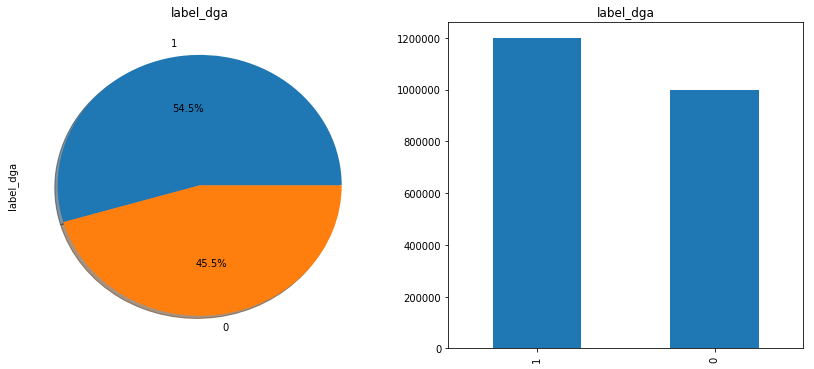

In [29]:
data['label_dga'] = data['label'].map(lambda x: 1 if not x=='legit' else 0)
# 各个类别的dga占比
f,ax=plt.subplots(1,2,figsize=(14,6))
data['label_dga'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('label_dga')
data['label_dga'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('label_dga')
plt.show()

#### 各个类别占比

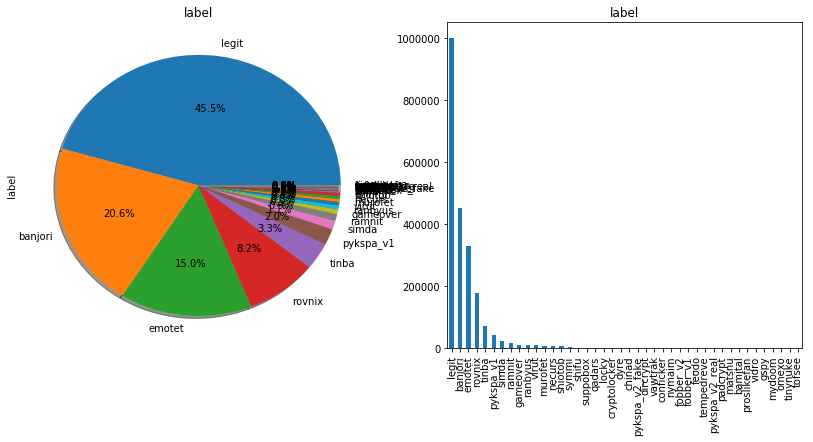

In [28]:
# 各个类别的dga占比
f,ax=plt.subplots(1,2,figsize=(14,6))
data['label'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('label')
data['label'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('label')
plt.show()

In [26]:
data_statis = pd.DataFrame()
label_counts = data['label'].value_counts()
data_statis['family'] = label_counts.index
data_statis['number'] = label_counts.values
data_statis['ratio'] = label_counts.values / np.sum(data_statis['number'])
data_statis

,family,number,ratio
0,legit,1000000,0.454556
1,banjori,452341,0.205614
2,emotet,330562,0.150259
3,rovnix,179935,0.081791
4,tinba,72490,0.032951
5,pykspa_v1,44278,0.020127
6,simda,23731,0.010787
7,ramnit,18935,0.008607
8,gameover,11997,0.005453
9,ranbyus,10903,0.004956


#### 训练与测试集划分

采用分层采样的原则，将数据据划分为0.8 0.2

In [27]:
X_train, X_test = train_test_split(data, test_size=0.2, stratify=data['label'])
X_train.shape, X_test.shape

((1759959, 2), (439990, 2))

# 3. 特征工程

In [30]:
# 加载已经处理好的特征文件
train_features_filepath = 'data/dataset/train_numeric.csv'
test_features_filepath = 'data/dataset/test_numeric.csv'
train_features_df = pd.read_csv(train_features_filepath)
test_features_df = pd.read_csv(test_features_filepath)
train_features_df.shape, test_features_df.shape

((1759959, 49), (439990, 49))

In [31]:
train_features_df.columns

Index(['domain', 'label', 'main_domain', 'tld', 'entropy', 'vowel_ratio',
       'digit_ratio', 'repeat_letter_ratio', 'consecutive_digits_ratio',
       'consecutive_consonant_ratio', 'gib', 'hmm_log', 'length', 'uni_ave',
       'bi_ave', 'tri_ave', 'uni_std', 'bi_std', 'tri_std', 'tld_0', 'tld_1',
       'tld_2', 'tld_3', 'tld_4', 'tld_5', 'tld_6', 'tld_7', 'tld_8', 'tld_9',
       'tld_10', 'tld_11', 'tld_12', 'tld_13', 'tld_14', 'tld_15', 'tld_16',
       'tld_17', 'tld_18', 'tld_19', 'tld_20', 'tld_21', 'tld_22', 'tld_23',
       'tld_24', 'tld_25', 'tld_26', 'tld_27', 'tld_28', 'tld_29'],
      dtype='object')

In [32]:
train_features_df.head()

,domain,label,main_domain,tld,entropy,vowel_ratio,digit_ratio,repeat_letter_ratio,consecutive_digits_ratio,consecutive_consonant_ratio,...,tld_20,tld_21,tld_22,tld_23,tld_24,tld_25,tld_26,tld_27,tld_28,tld_29
0,nlwpvkhlxitcjiej.eu,emotet,nlwpvkhlxitcjiej,eu,2.512659,0.187500,0.0,0.187500,0.0,0.750000,...,2.723791e-16,-1.435627e-15,1.227174e-15,1.064156e-14,-5.007343e-17,5.994943e-15,4.278799e-16,-3.721696e-16,-7.395807e-15,2.791984e-15
1,lifespa.com,legit,lifespa,com,1.945910,0.428571,0.0,0.000000,0.0,0.285714,...,-1.607818e-18,1.243457e-18,-1.974010e-18,-1.924975e-17,2.423300e-18,-1.436490e-17,3.957242e-18,3.718585e-18,-3.527445e-18,1.182715e-17
2,sedes.org.br,legit,sedes,org.br,1.054920,0.400000,0.0,0.400000,0.0,0.000000,...,-4.226024e-07,-3.377123e-06,-7.597923e-07,3.135754e-05,3.792294e-06,2.058674e-05,4.911968e-06,-2.102178e-05,-1.956920e-05,4.067783e-06
3,dbedestnessbiophysicalohax.com,banjori,dbedestnessbiophysicalohax,com,2.598143,0.346154,0.0,0.307692,0.0,0.461538,...,-1.607818e-18,1.243457e-18,-1.974010e-18,-1.924975e-17,2.423300e-18,-1.436490e-17,3.957242e-18,3.718585e-18,-3.527445e-18,1.182715e-17
4,fnnvanerraticallyqozaw.com,banjori,fnnvanerraticallyqozaw,com,2.563151,0.318182,0.0,0.181818,0.0,0.454545,...,-1.607818e-18,1.243457e-18,-1.974010e-18,-1.924975e-17,2.423300e-18,-1.436490e-17,3.957242e-18,3.718585e-18,-3.527445e-18,1.182715e-17


### 基本特征 - 随机性和熵

#### 香农熵分布

/home/lili/anaconda3/envs/dga_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


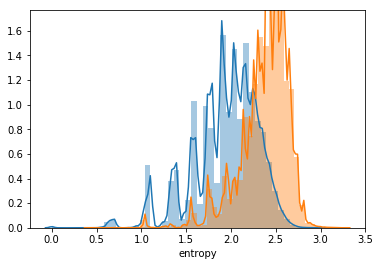

In [33]:
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['entropy'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['entropy'])

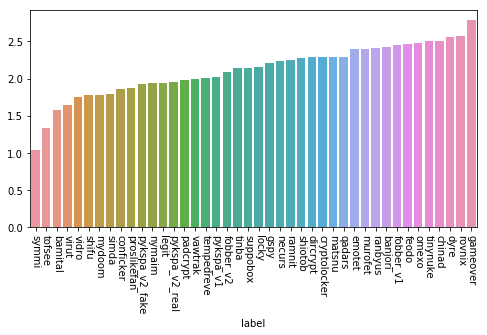

In [317]:
entropy_mean = train_features_df.groupby(['label']).apply(lambda x: x['entropy'].mean()).sort_values()
f,ax=plt.subplots(1,1,figsize=(8,4))
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
sns.barplot(x=entropy_mean.index, y=entropy_mean)

### 高级特征

#### 合法域名一般比较好念出来，C&C域名不好念

##### 元音字母比重

/home/lili/anaconda3/envs/dga_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


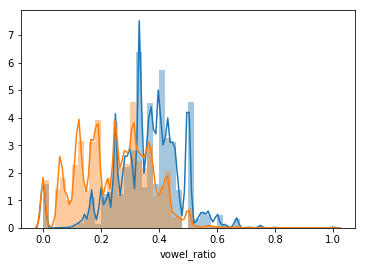

In [35]:
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['vowel_ratio'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['vowel_ratio'])

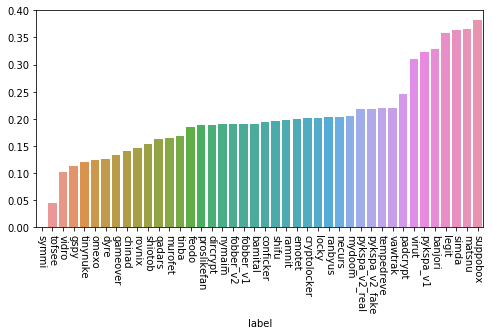

In [316]:
vowel_ratio_mean = train_features_df.groupby(['label']).apply(lambda x: x['vowel_ratio'].mean()).sort_values()
f,ax=plt.subplots(1,1,figsize=(8,4))
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
sns.barplot(x=vowel_ratio_mean.index, y=vowel_ratio_mean)

##### gibberish

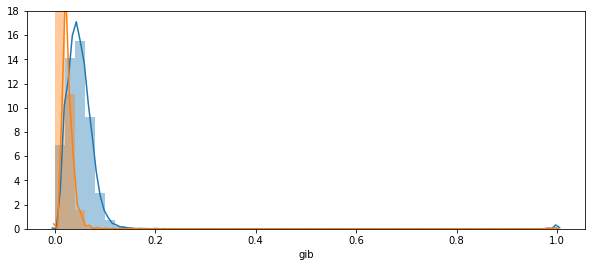

In [319]:
f,ax=plt.subplots(1,1,figsize=(10,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['gib'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['gib'])

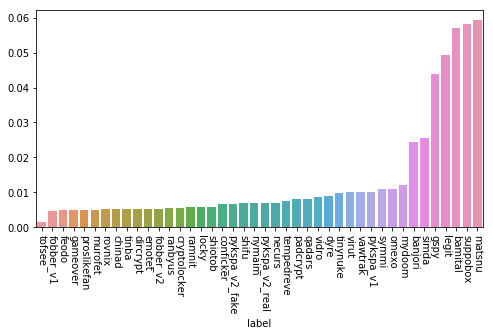

In [315]:
gib_mean = train_features_df.groupby(['label']).apply(lambda x: x['gib'].mean()).sort_values()
f,ax=plt.subplots(1,1,figsize=(8,4))
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
sns.barplot(x=gib_mean.index, y=gib_mean)

#### 连续vs分散

##### 数字字母占比

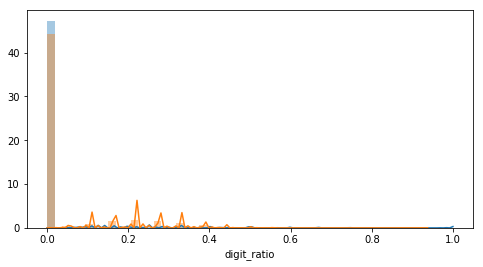

In [320]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['digit_ratio'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['digit_ratio'])

##### 重复字母占比

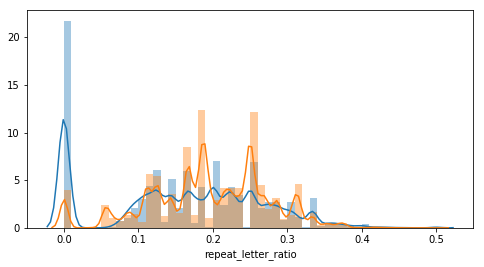

In [321]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['repeat_letter_ratio'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['repeat_letter_ratio'])

##### 连续数字占比

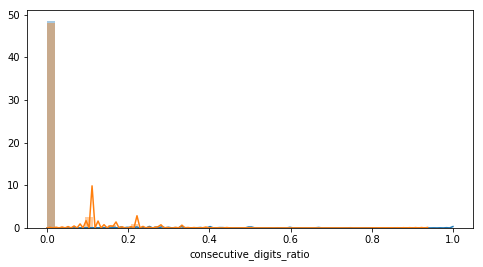

In [322]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['consecutive_digits_ratio'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['consecutive_digits_ratio'])

##### 连续辅音占比

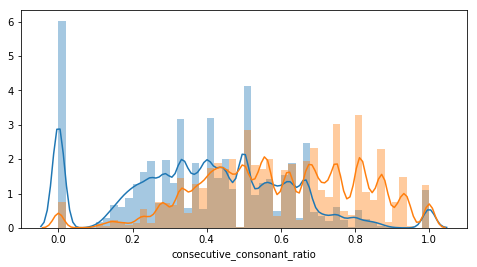

In [323]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['consecutive_consonant_ratio'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['consecutive_consonant_ratio'])

#### n-gram平均排名

##### uni-ave、uni-std

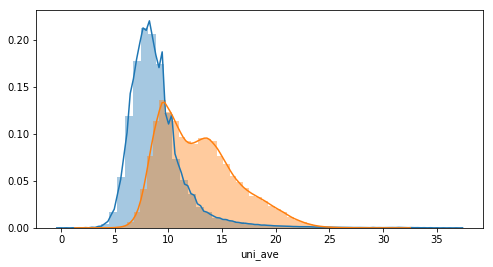

In [324]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['uni_ave'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['uni_ave'])

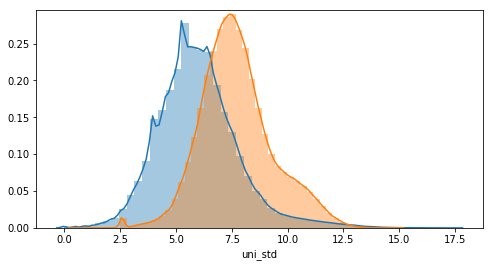

In [325]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['uni_std'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['uni_std'])

##### bi-ave、uni-std

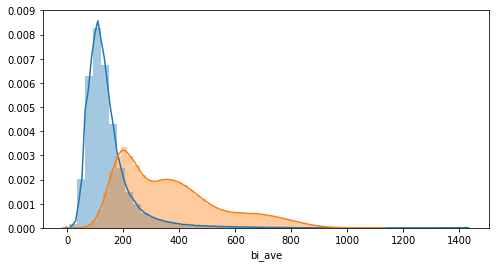

In [326]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['bi_ave'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['bi_ave'])

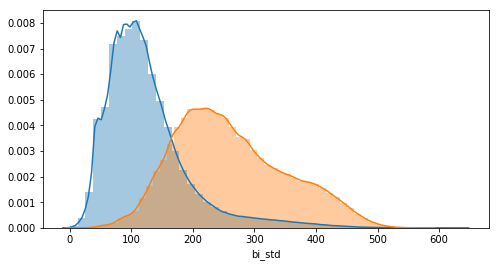

In [327]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['bi_std'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['bi_std'])

##### tri-ave、tri-std

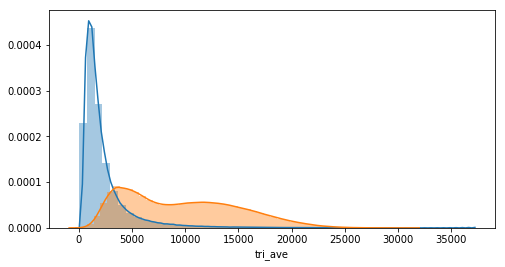

In [328]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['tri_ave'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['tri_ave'])

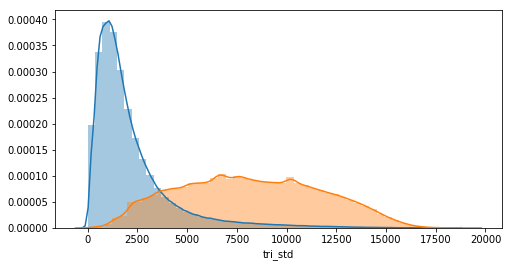

In [329]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['tri_std'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['tri_std'])

#### HMM概率

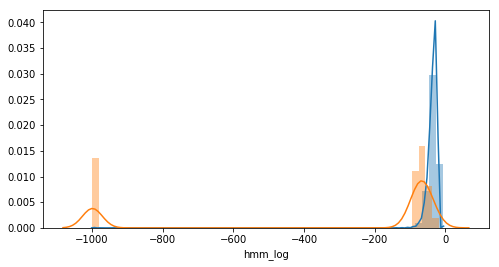

In [330]:
f,ax=plt.subplots(1,1,figsize=(8,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['hmm_log'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['hmm_log'])

### 领域特征

#### ccTLD特征

我们知道多数情况下.com的域名申请又贵又要审核，所以现在很多C&C不会选择.com，反而会选一些审核不严的比如.biz .info .ru .ws以及最近爆发的.xyz之类的ccTLD都是C&C重灾区。中国的白帽专家也可能知道.cn现在申请都得备案，所以C&C也不太可能用.cn的根域名当作C&C。值得提醒的是，这些情况并非100%确定，比如C&C可能找到一个cn域名的下级域名当C&C而主域名已备案，这些需要机器综合考虑其他特征来判断。

In [63]:
tld_df = pd.DataFrame()
legit_tld = train_features_df.loc[train_features_df['label']=='legit']['tld'].value_counts()
dga_tld = train_features_df.loc[train_features_df['label']!='legit']['tld'].value_counts()
tld_df['legit'] = legit_tld
tld_df['legit_ratio'] = tld_df['legit'] / np.sum(tld_df['legit'])
tld_df['dga'] = dga_tld
tld_df['dga_ratio'] = tld_df['dga'] / np.sum(tld_df['dga'])
tld_df.head(10)

,legit,dga,legit_ratio,dga_ratio
com,375750,458675.0,0.469687,0.477920
org,39527,10786.0,0.049409,0.011239
net,33656,57059.0,0.042070,0.059453
ru,33606,38192.0,0.042008,0.039794
de,32594,146.0,0.040743,0.000152
co.uk,15822,120.0,0.019777,0.000125
it,12102,4.0,0.015128,0.000004
com.br,11964,NaN,0.014955,NaN
ir,11903,167.0,0.014879,0.000174
fr,10340,4.0,0.012925,0.000004


#### 域名长度

/home/lili/anaconda3/envs/dga_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


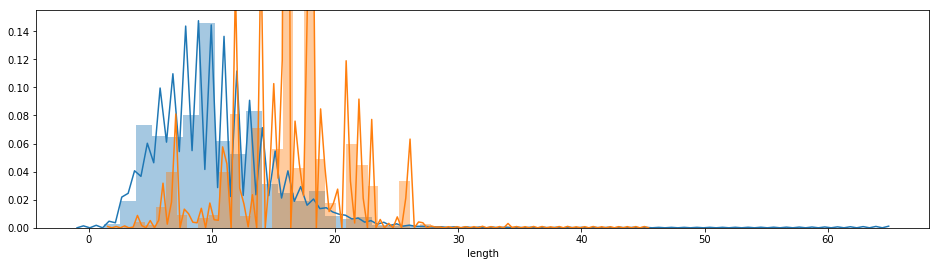

In [56]:
f,ax=plt.subplots(1,1,figsize=(16,4))
sns.distplot(train_features_df.loc[train_features_df['label']=='legit']['length'])
sns.distplot(train_features_df.loc[train_features_df['label']!='legit']['length'])

# 4. 模型验证

## 0. 数据处理

In [66]:
useful_features_name = ['entropy', 'vowel_ratio',
       'digit_ratio', 'repeat_letter_ratio', 'consecutive_digits_ratio',
       'consecutive_consonant_ratio', 'gib', 'hmm_log', 'length', 'uni_ave',
       'bi_ave', 'tri_ave', 'uni_std', 'bi_std', 'tri_std', 'tld_0', 'tld_1',
       'tld_2', 'tld_3', 'tld_4', 'tld_5', 'tld_6', 'tld_7', 'tld_8', 'tld_9',
       'tld_10', 'tld_11', 'tld_12', 'tld_13', 'tld_14', 'tld_15', 'tld_16',
       'tld_17', 'tld_18', 'tld_19', 'tld_20', 'tld_21', 'tld_22', 'tld_23',
       'tld_24', 'tld_25', 'tld_26', 'tld_27', 'tld_28', 'tld_29']
label = ['label']

In [67]:
X_train = train_features_df[useful_features_name]
y_train = train_features_df['label'].map(lambda x: 1 if x != 'legit' else 0)
X_test = test_features_df[useful_features_name]
y_test = test_features_df['label'].map(lambda x: 1 if x != 'legit' else 0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1759959, 45), (1759959,), (439990, 45), (439990,))

In [287]:
classes_ = train_features_df['label'].unique()
family_dict = {classes_[idx]:idx for idx in range(classes_.shape[0])}
y_train_mul = train_features_df['label'].map(family_dict)  # label encoder
y_test_mul = test_features_df['label'].map(family_dict)
y_train_multi = np_utils.to_categorical(y_train_mul)  # one-hot encoder
y_test_multi = np_utils.to_categorical(y_test_mul)
y_train_mul.shape, y_test_mul.shape, len(family_dict), y_train_multi.shape, y_test_multi.shape

((1759959,), (439990,), 42, (1759959, 42), (439990, 42))

### 数字特征

#### 归一化

In [70]:
min_max_scaler = MinMaxScaler().fit(X_train.values)
X_train_min_max_scaler = min_max_scaler.transform(X_train.values)
X_test_min_max_scaler = min_max_scaler.transform(X_test.values)
X_train_min_max_scaler.shape, X_test_min_max_scaler.shape

((1759959, 45), (439990, 45))

#### 选取部分数据训练与测试

In [72]:
train_size, test_size = 100000, 20000
X_train_10w = X_train_min_max_scaler[:train_size]
y_train_10w = y_train.values[:train_size]
X_test_10w = X_test_min_max_scaler[:test_size]
y_test_10w = y_test.values[:test_size]
X_train_10w.shape, y_train_10w.shape, X_test_10w.shape, y_test_10w.shape

((100000, 45), (100000,), (20000, 45), (20000,))

In [290]:
y_train_mul_10w = y_train_mul.values[:train_size]
y_test_mul_10w = y_test_mul.values[:test_size]
y_train_multi_10w = y_train_multi[:train_size]
y_test_multi_10w = y_test_multi[:test_size]
y_train_mul_10w.shape, y_test_mul_10w.shape, y_train_multi.shape, y_test_multi.shape

((100000,), (20000,), (1759959, 42), (439990, 42))

### 文本特征

In [150]:
X_train_domain = train_features_df['main_domain']
X_test_domain = test_features_df['main_domain']

In [265]:
X_train_deep, domain_max_features, domain_maxlen= get_feature_vectors('model/nlp/', 
                                                                      'nlp_valid_chars_API.pkl', 
                                                                      X_train_domain.fillna('').tolist())  # 编码特征
X_test_deep, *rst = get_feature_vectors('model/nlp/', 
                                        'nlp_valid_chars_API.pkl', 
                                        X_test_domain.fillna('').tolist())

In [266]:
train_size, test_size = 100000, 20000

X_train_deep_10w = X_train_deep[:train_size]
y_train_deep_10w = y_train.values[:train_size]
X_test_deep_10w = X_test_deep[:test_size]
y_test_deep_10w = y_test.values[:test_size]
X_train_deep_10w.shape, y_train_deep_10w.shape, X_test_deep_10w.shape, y_test_deep_10w.shape

((100000, 64), (100000,), (20000, 64), (20000,))

In [291]:
y_train_deep_mul_10w = y_train_mul.values[:train_size]
y_test_deep_mul_10w = y_test_mul.values[:test_size]
y_train_deep_multi_10w = y_train_multi[:train_size]
y_test_deep_multi_10w = y_test_multi[:test_size]
y_train_deep_mul_10w.shape, y_test_deep_mul_10w.shape, y_train_deep_multi_10w.shape, y_test_deep_multi_10w.shape

((100000,), (20000,), (100000, 42), (20000, 42))

### 一些函数

In [351]:
# 评估函数
def evaluate_result(label, y_pred=None, y_proba=None):
    if y_pred is None:
        y_pred = np.where(y_proba>0.5, 1, 0)
    
    accuracy = accuracy_score(label, y_pred)
    precision = precision_score(label, y_pred)
    recall = recall_score(label, y_pred)
    f1 = 2*(precision*recall)/(precision+recall)
   
    if y_proba is None: 
        roc = 0
    else:
        roc = roc_auc_score(label, y_proba)
        
    confusion = confusion_matrix(label, y_pred)
    print("Accuracy: {:.4f}% \t Precision: {:.4f}% \t Recall: {:.4f}% \t Roc: {:.4f}\tF1: {:.4f}".format(accuracy*100, 
                                                                                                         precision*100, 
                                                                                                         recall*100, 
                                                                                                         roc,
                                                                                                         f1))
    print("Confusion:")
    print(confusion)
    
# 加载模型
def load_model(name):
    architecture_path = "model/{}/{}_model_architecture.json".format(name, name)
    weight_path = "model/{}/{}_model_weights.best.h5".format(name, name)
    model = model_from_json(open(architecture_path).read(),
                            custom_objects={'AttentionLayer': att.AttentionLayer})
    model.load_weights(weight_path)
    return model


'''
    序列化main_domain特征
    save_dir：保存位置
    X：
'''
def get_feature_vectors(save_dir, filename, X):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    file_path = save_dir + filename
    if not os.path.exists(file_path):
        valid_chars = {x: idx + 1 for idx, x in enumerate(set(''.join(X)))}  # 统计有效字符出现的次数
        max_features = len(valid_chars) + 1  # 有效字符长度+1
        maxlen = np.max([len(x) for x in X])  # 最长域名的长度
        # save the dictionary of valid characters
        valid_chars['maxlen'] = maxlen
        pickle.dump(valid_chars, open(file_path, 'wb'))
        
    valid_chars = pickle.load(open(file_path, 'rb'))
    max_features = len(valid_chars) # 有效字符长度
    maxlen = valid_chars['maxlen']
    del (valid_chars['maxlen'])
    
    X = [[valid_chars.get(y, 0) for y in x] for x in X]
    X = sequence.pad_sequences(X, maxlen=maxlen)  # 形成长度相同的序列
    return X, max_features, maxlen

## 4.1 Machine Learning

### logstic

In [100]:
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train_10w, y_train_10w)
joblib.dump(log_reg, 'model/logstic/logstic_10w.model')

['model/logstic/logstic_10w.model']

In [339]:
evaluate_result(y_train_10w, log_reg.predict(X_train_10w), log_reg.predict_proba(X_train_10w)[:,1])
evaluate_result(y_test_10w, log_reg.predict(X_test_10w), log_reg.predict_proba(X_test_10w)[:,1])

Accuracy: 95.1960% 	 Precision: 96.0374% 	 Recall: 95.0949% 	 Roc: 0.9888	F1: 0.9556
Confusion:
[[43452  2135]
 [ 2669 51744]]
Accuracy: 95.2900% 	 Precision: 96.1861% 	 Recall: 95.1864% 	 Roc: 0.9893	F1: 0.9568
Confusion:
[[ 8617   414]
 [  528 10441]]


#### 查看权重系数

In [83]:
linear_weight = { useful_features_name[i]:log_reg.coef_[0, i] for i in range(45)}
linear_weight = pd.Series(linear_weight)

In [93]:
linear_weight_df = pd.DataFrame()
linear_weight_df['feature'] = linear_weight.index
linear_weight_df['weight'] = linear_weight.values
linear_weight_df['absolute_weight'] = np.abs(linear_weight.values)

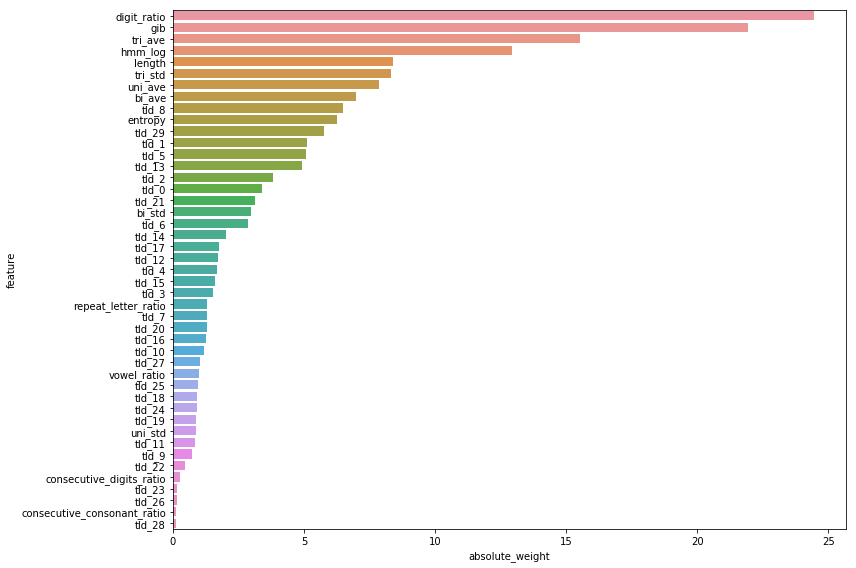

In [97]:
plt.figure(figsize=(12,8))
sns.barplot(x="absolute_weight", y="feature", data=linear_weight_df.sort_values(by="absolute_weight",ascending=False))
plt.tight_layout()

### SVM

#### svm 调参至最佳参数
- 由于SVM训练实在缓慢，故此在小数据集上寻找出一组参数后，再应用与大数据集

In [106]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), 
                       "C": uniform(1, 10)}

rnd_search_cv = RandomizedSearchCV(SVC(), 
                                   param_distributions, 
                                   n_iter=100, 
                                   verbose=2, 
                                   cv=3)

rnd_search_cv.fit(X_train_10w[:5000], y_train_10w[:5000])
rnd_search_cv.best_estimator_,rnd_search_cv.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=4.24023234172, gamma=0.027864182986 ...........................
[CV] ............ C=4.24023234172, gamma=0.027864182986, total=   0.4s
[CV] C=4.24023234172, gamma=0.027864182986 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ............ C=4.24023234172, gamma=0.027864182986, total=   0.4s
[CV] C=4.24023234172, gamma=0.027864182986 ...........................
[CV] ............ C=4.24023234172, gamma=0.027864182986, total=   0.4s
[CV] C=2.82394459439, gamma=0.00563384128224 .........................
[CV] .......... C=2.82394459439, gamma=0.00563384128224, total=   0.5s
[CV] C=2.82394459439, gamma=0.00563384128224 .........................
[CV] .......... C=2.82394459439, gamma=0.00563384128224, total=   0.5s
[CV] C=2.82394459439, gamma=0.00563384128224 .........................
[CV] .......... C=2.82394459439, gamma=0.00563384128224, total=   0.5s
[CV] C=5.96597597003, gamma=0.00522424540472 .........................
[CV] .......... C=5.96597597003, gamma=0.00522424540472, total=   0.4s
[CV] C=5.96597597003, gamma=0.00522424540472 .........................
[CV] .......... C=5.96597597003, gamma=0.00522424540472, total=   0.4s
[CV] C=5.96597597003, gamma=0.00522424540472 .........................
[CV] .

[CV] ............ C=1.5864626082, gamma=0.0477832637476, total=   0.4s
[CV] C=2.44256396435, gamma=0.00436003144247 .........................
[CV] .......... C=2.44256396435, gamma=0.00436003144247, total=   0.6s
[CV] C=2.44256396435, gamma=0.00436003144247 .........................
[CV] .......... C=2.44256396435, gamma=0.00436003144247, total=   0.6s
[CV] C=2.44256396435, gamma=0.00436003144247 .........................
[CV] .......... C=2.44256396435, gamma=0.00436003144247, total=   0.6s
[CV] C=8.70588598327, gamma=0.0260224683207 ..........................
[CV] ........... C=8.70588598327, gamma=0.0260224683207, total=   0.3s
[CV] C=8.70588598327, gamma=0.0260224683207 ..........................
[CV] ........... C=8.70588598327, gamma=0.0260224683207, total=   0.3s
[CV] C=8.70588598327, gamma=0.0260224683207 ..........................
[CV] ........... C=8.70588598327, gamma=0.0260224683207, total=   0.3s
[CV] C=4.7481943668, gamma=0.00612768607146 ..........................
[CV] .

[CV] ........... C=10.7167056104, gamma=0.0245614812226, total=   0.3s
[CV] C=10.7167056104, gamma=0.0245614812226 ..........................
[CV] ........... C=10.7167056104, gamma=0.0245614812226, total=   0.3s
[CV] C=10.7167056104, gamma=0.0245614812226 ..........................
[CV] ........... C=10.7167056104, gamma=0.0245614812226, total=   0.3s
[CV] C=8.28915202608, gamma=0.0158768369968 ..........................
[CV] ........... C=8.28915202608, gamma=0.0158768369968, total=   0.3s
[CV] C=8.28915202608, gamma=0.0158768369968 ..........................
[CV] ........... C=8.28915202608, gamma=0.0158768369968, total=   0.3s
[CV] C=8.28915202608, gamma=0.0158768369968 ..........................
[CV] ........... C=8.28915202608, gamma=0.0158768369968, total=   0.3s
[CV] C=2.99106819276, gamma=0.0802837477644 ..........................
[CV] ........... C=2.99106819276, gamma=0.0802837477644, total=   0.3s
[CV] C=2.99106819276, gamma=0.0802837477644 ..........................
[CV] .

[CV] ........... C=3.11680445944, gamma=0.0135441864665, total=   0.4s
[CV] C=3.11680445944, gamma=0.0135441864665 ..........................
[CV] ........... C=3.11680445944, gamma=0.0135441864665, total=   0.4s
[CV] C=6.53178783083, gamma=0.0359555694885 ..........................
[CV] ........... C=6.53178783083, gamma=0.0359555694885, total=   0.3s
[CV] C=6.53178783083, gamma=0.0359555694885 ..........................
[CV] ........... C=6.53178783083, gamma=0.0359555694885, total=   0.3s
[CV] C=6.53178783083, gamma=0.0359555694885 ..........................
[CV] ........... C=6.53178783083, gamma=0.0359555694885, total=   0.3s
[CV] C=9.08598751026, gamma=0.057376039859 ...........................
[CV] ............ C=9.08598751026, gamma=0.057376039859, total=   0.3s
[CV] C=9.08598751026, gamma=0.057376039859 ...........................
[CV] ............ C=9.08598751026, gamma=0.057376039859, total=   0.3s
[CV] C=9.08598751026, gamma=0.057376039859 ...........................
[CV] .

[CV] ........... C=5.64536064064, gamma=0.0208251584319, total=   0.3s
[CV] C=9.87691099873, gamma=0.00170217261314 .........................
[CV] .......... C=9.87691099873, gamma=0.00170217261314, total=   0.5s
[CV] C=9.87691099873, gamma=0.00170217261314 .........................
[CV] .......... C=9.87691099873, gamma=0.00170217261314, total=   0.5s
[CV] C=9.87691099873, gamma=0.00170217261314 .........................
[CV] .......... C=9.87691099873, gamma=0.00170217261314, total=   0.5s
[CV] C=1.04028371476, gamma=0.00323654917749 .........................
[CV] .......... C=1.04028371476, gamma=0.00323654917749, total=   0.8s
[CV] C=1.04028371476, gamma=0.00323654917749 .........................
[CV] .......... C=1.04028371476, gamma=0.00323654917749, total=   0.8s
[CV] C=1.04028371476, gamma=0.00323654917749 .........................
[CV] .......... C=1.04028371476, gamma=0.00323654917749, total=   0.8s
[CV] C=2.05044656099, gamma=0.00831220156027 .........................
[CV] .

[CV] .......... C=6.81033749598, gamma=0.00343392837294, total=   0.5s
[CV] C=6.81033749598, gamma=0.00343392837294 .........................
[CV] .......... C=6.81033749598, gamma=0.00343392837294, total=   0.5s
[CV] C=6.81033749598, gamma=0.00343392837294 .........................
[CV] .......... C=6.81033749598, gamma=0.00343392837294, total=   0.5s
[CV] C=6.88275525112, gamma=0.0532227200286 ..........................
[CV] ........... C=6.88275525112, gamma=0.0532227200286, total=   0.3s
[CV] C=6.88275525112, gamma=0.0532227200286 ..........................
[CV] ........... C=6.88275525112, gamma=0.0532227200286, total=   0.3s
[CV] C=6.88275525112, gamma=0.0532227200286 ..........................
[CV] ........... C=6.88275525112, gamma=0.0532227200286, total=   0.3s
[CV] C=6.68881962627, gamma=0.0121829495276 ..........................
[CV] ........... C=6.68881962627, gamma=0.0121829495276, total=   0.3s
[CV] C=6.68881962627, gamma=0.0121829495276 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.2min finished


(SVC(C=10.892521860571078, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.089400468476754411,
   kernel='rbf', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False), 0.94720000000000004)

In [ ]:
# rbf核
svm_clf = SVC(C=10.892521860571078,
              gamma=0.089400468476754411)
svm_clf.fit(X_train_10w, y_train_10w)
joblib.dump(svm_clf, 'model/svm/svm_rbf_10w.model')

In [344]:
svm_clf = joblib.load('model/svm/svm_rbf_10w.model')
evaluate_result(y_train_10w, svm_clf.predict(X_train_10w))
evaluate_result(y_test_10w, svm_clf.predict(X_test_10w))

Accuracy: 96.4030% 	 Precision: 97.0170% 	 Recall: 96.3520% 	 Roc: 0.0000	F1: 0.9668
Confusion:
[[43975  1612]
 [ 1985 52428]]
Accuracy: 96.5300% 	 Precision: 97.2327% 	 Recall: 96.4172% 	 Roc: 0.0000	F1: 0.9682
Confusion:
[[ 8730   301]
 [  393 10576]]


### lightgbm

In [111]:
params = {
          'num_leaves': 31,
          'min_data_in_leaf': 20,
          'objective': 'binary', # 定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt", 
          "feature_fraction": 0.9,  # 提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,       # l1正则
          'lambda_l2': 0.001,     # l2正则
          "verbosity": -1,
          "nthread": 16,          # 线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 42,     #随机数种子，可以防止每次运行的结果不一致
          }

trn_data = lgb.Dataset(X_train_10w, label=y_train_10w)
tst_data = lgb.Dataset(X_test_10w, label=y_test_10w)
lgb_clf = lgb.train(params, 
                    trn_data,
                    10000,
                    valid_sets=[trn_data, tst_data],
                    verbose_eval=20,
                    early_stopping_rounds=60)
pickle.dump(lgb_clf, open('model/lgb/lgb_10w.pkl', 'wb'))

Training until validation scores don't improve for 60 rounds.
[20]	training's binary_logloss: 0.362421	training's auc: 0.991977	valid_1's binary_logloss: 0.371994	valid_1's auc: 0.990606
[40]	training's binary_logloss: 0.222215	training's auc: 0.993058	valid_1's binary_logloss: 0.240586	valid_1's auc: 0.991275
[60]	training's binary_logloss: 0.153177	training's auc: 0.994028	valid_1's binary_logloss: 0.169953	valid_1's auc: 0.992666
[80]	training's binary_logloss: 0.115946	training's auc: 0.995036	valid_1's binary_logloss: 0.130251	valid_1's auc: 0.993968
[100]	training's binary_logloss: 0.0941161	training's auc: 0.995782	valid_1's binary_logloss: 0.108418	valid_1's auc: 0.994653
[120]	training's binary_logloss: 0.0810619	training's auc: 0.996436	valid_1's binary_logloss: 0.0945204	valid_1's auc: 0.995465
[140]	training's binary_logloss: 0.071739	training's auc: 0.99719	valid_1's binary_logloss: 0.0837593	valid_1's auc: 0.996227
[160]	training's binary_logloss: 0.0650052	training's auc

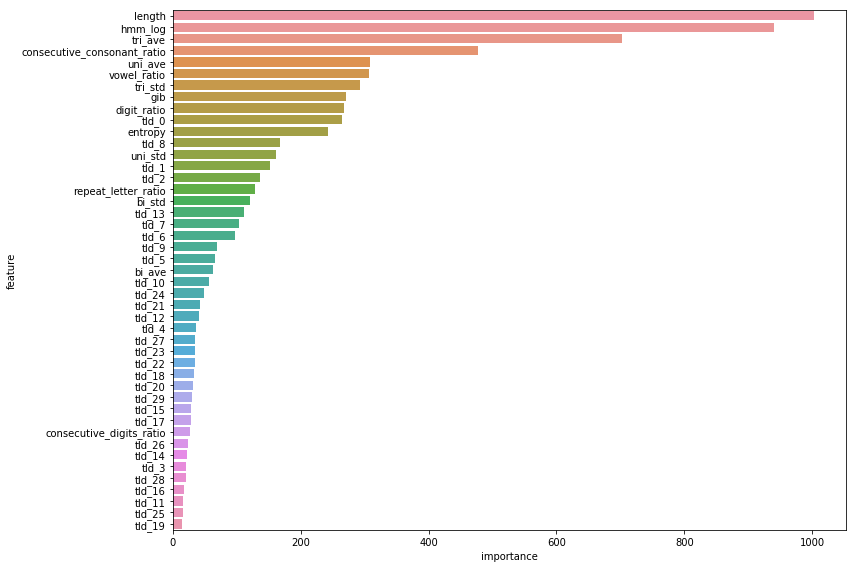

In [147]:
lgb_importance_df = pd.DataFrame()
lgb_importance_df["feature"] = useful_features_name
lgb_importance_df["importance"] = lgb_clf.feature_importance()

plt.figure(figsize=(12,8))
sns.barplot(x="importance", y="feature", data=lgb_importance_df.sort_values(by="importance",ascending=False))
plt.tight_layout()

In [345]:
# lgb_clf = pickle.load(open('model/lgb/lgb_10w.pkl', 'rb'))
evaluate_result(y_train_10w, None, lgb_clf.predict(X_train_10w))
evaluate_result(y_test_10w, None, lgb_clf.predict(X_test_10w))

Accuracy: 98.2690% 	 Precision: 98.4869% 	 Recall: 98.3294% 	 Roc: 0.9985	F1: 0.9841
Confusion:
[[44765   822]
 [  909 53504]]
Accuracy: 97.5250% 	 Precision: 98.9348% 	 Recall: 96.5266% 	 Roc: 0.9978	F1: 0.9772
Confusion:
[[ 8917   114]
 [  381 10588]]


## 4.2 Deep Learning

### DNN

In [333]:
def create_dnn_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=45))
    model.add(Dropout(rate=0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [336]:
dnn_model = create_dnn_model()

filepath = 'model/dnn/dnn_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

dnn_history=dnn_model.fit(X_train_10w, y_train_10w, epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = dnn_model.to_json()  # 保存模型结构
open('model/dnn/dnn_model_architecture.json', 'w').write(json_string)

pickle.dump(dnn_history.history, open('model/dnn/dnn_history.pkl', 'wb'))

In [346]:
dnn_model = load_model('dnn')
evaluate_result(y_train_10w, None, dnn_model.predict(X_train_10w))
evaluate_result(y_test_10w, None, dnn_model.predict(X_test_10w))

Accuracy: 97.1040% 	 Precision: 97.5644% 	 Recall: 97.1018% 	 Roc: 0.9962	F1: 0.9733
Confusion:
[[44268  1319]
 [ 1577 52836]]
Accuracy: 97.2550% 	 Precision: 97.7019% 	 Recall: 97.2833% 	 Roc: 0.9964	F1: 0.9749
Confusion:
[[ 8780   251]
 [  298 10671]]


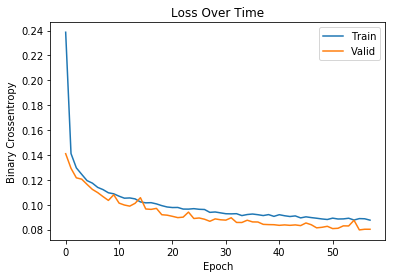

In [338]:
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

### LSTM 

In [155]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(domain_max_features, 
                        128, 
                        input_length=domain_maxlen))
    model.add(LSTM(128))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [347]:
lstm_model = create_lstm_model()

filepath = 'model/lstm/lstm_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

lstm_history = lstm_model.fit(X_train_deep_10w, y_train_deep_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = lstm_model.to_json()  # 保存模型结构
open('model/lstm/lstm_model_architecture.json', 'w').write(json_string)

pickle.dump(lstm_history.history, open('model/lstm/lstm_history.pkl', 'wb'))

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 37s - loss: 0.2458 - acc: 0.9053 - val_loss: 0.1972 - val_acc: 0.9244
Epoch 2/500
90000/90000 [==============================] - 32s - loss: 0.1689 - acc: 0.9387 - val_loss: 0.1483 - val_acc: 0.9487
Epoch 3/500
90000/90000 [==============================] - 32s - loss: 0.1364 - acc: 0.9518 - val_loss: 0.1242 - val_acc: 0.9563
Epoch 4/500
90000/90000 [==============================] - 31s - loss: 0.1236 - acc: 0.9559 - val_loss: 0.1133 - val_acc: 0.9614
Epoch 5/500
90000/90000 [==============================] - 32s - loss: 0.0994 - acc: 0.9659 - val_loss: 0.0930 - val_acc: 0.9687
Epoch 6/500
90000/90000 [==============================] - 32s - loss: 0.0859 - acc: 0.9709 - val_loss: 0.0878 - val_acc: 0.9703
Epoch 7/500
90000/90000 [==============================] - 31s - loss: 0.0793 - acc: 0.9730 - val_loss: 0.0801 - val_acc: 0.9728
Epoch 8/500
90000/90000 [======================

In [348]:
lstm_model = load_model('lstm')
evaluate_result(y_train_deep_10w, None, lstm_model.predict(X_train_deep_10w))
evaluate_result(y_test_deep_10w, None, lstm_model.predict(X_test_deep_10w))

Accuracy: 99.7540% 	 Precision: 99.8307% 	 Recall: 99.7170% 	 Roc: 0.9998	F1: 0.9977
Confusion:
[[45495    92]
 [  154 54259]]
Accuracy: 98.4750% 	 Precision: 98.7921% 	 Recall: 98.4228% 	 Roc: 0.9977	F1: 0.9861
Confusion:
[[ 8899   132]
 [  173 10796]]


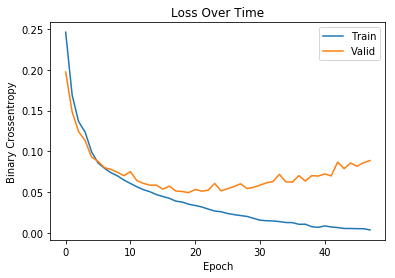

In [349]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

### biLSTM

In [354]:
def create_bilstm_model():
    model = Sequential()
    model.add(Embedding(domain_max_features, 
                        128, 
                        input_length=domain_maxlen))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(att.AttentionLayer())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [355]:
reload(att)
bilstm_model = create_bilstm_model()

filepath = 'model/bilstm/bilstm_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

bilstm_history = bilstm_model.fit(X_train_deep_10w, y_train_deep_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = bilstm_model.to_json()  # 保存模型结构
open('model/bilstm/bilstm_model_architecture.json', 'w').write(json_string)

pickle.dump(bilstm_history.history, open('model/bilstm/bilstm_history.pkl', 'wb'))

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 66s - loss: 0.2707 - acc: 0.8849 - val_loss: 0.2077 - val_acc: 0.9191
Epoch 2/500
90000/90000 [==============================] - 63s - loss: 0.1867 - acc: 0.9279 - val_loss: 0.1749 - val_acc: 0.9344
Epoch 3/500
90000/90000 [==============================] - 62s - loss: 0.1559 - acc: 0.9416 - val_loss: 0.1521 - val_acc: 0.9443
Epoch 4/500
90000/90000 [==============================] - 62s - loss: 0.1339 - acc: 0.9505 - val_loss: 0.1296 - val_acc: 0.9527
Epoch 5/500
90000/90000 [==============================] - 62s - loss: 0.1239 - acc: 0.9547 - val_loss: 0.1160 - val_acc: 0.9586
Epoch 6/500
90000/90000 [==============================] - 63s - loss: 0.0973 - acc: 0.9649 - val_loss: 0.0981 - val_acc: 0.9644
Epoch 7/500
90000/90000 [==============================] - 63s - loss: 0.0849 - acc: 0.9696 - val_loss: 0.0811 - val_acc: 0.9717
Epoch 8/500
90000/90000 [======================

In [356]:
bilstm_model = load_model('bilstm')
evaluate_result(y_train_deep_10w, None, bilstm_model.predict(X_train_deep_10w))
evaluate_result(y_test_deep_10w, None, bilstm_model.predict(X_test_deep_10w))

Accuracy: 99.4350% 	 Precision: 99.6240% 	 Recall: 99.3366% 	 Roc: 0.9994	F1: 0.9948
Confusion:
[[45383   204]
 [  361 54052]]
Accuracy: 98.4350% 	 Precision: 98.8538% 	 Recall: 98.2861% 	 Roc: 0.9974	F1: 0.9857
Confusion:
[[ 8906   125]
 [  188 10781]]


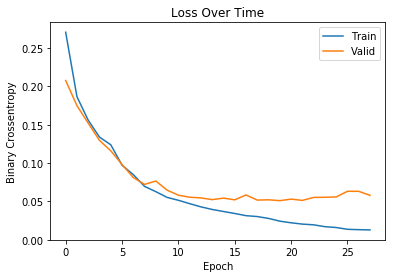

In [357]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

### GRU

In [358]:
def create_gru_model():
    model = Sequential()
    model.add(Embedding(domain_max_features, 
                        128, 
                        input_length=domain_maxlen))
    model.add(GRU(128))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [359]:
gru_model = create_gru_model()

filepath = 'model/gru/gru_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

gru_history = gru_model.fit(X_train_deep_10w, y_train_deep_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = gru_model.to_json()  # 保存模型结构
open('model/gru/gru_model_architecture.json', 'w').write(json_string)

pickle.dump(gru_history.history, open('model/gru/gru_history.pkl', 'wb'))

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 32s - loss: 0.2324 - acc: 0.9128 - val_loss: 0.1801 - val_acc: 0.9341
Epoch 2/500
90000/90000 [==============================] - 28s - loss: 0.1565 - acc: 0.9437 - val_loss: 0.1451 - val_acc: 0.9490
Epoch 3/500
90000/90000 [==============================] - 28s - loss: 0.1257 - acc: 0.9560 - val_loss: 0.1122 - val_acc: 0.9601
Epoch 4/500
90000/90000 [==============================] - 28s - loss: 0.0982 - acc: 0.9659 - val_loss: 0.0876 - val_acc: 0.9699
Epoch 5/500
90000/90000 [==============================] - 28s - loss: 0.0781 - acc: 0.9734 - val_loss: 0.0747 - val_acc: 0.9751
Epoch 6/500
90000/90000 [==============================] - 28s - loss: 0.0654 - acc: 0.9780 - val_loss: 0.0659 - val_acc: 0.9764
Epoch 7/500
90000/90000 [==============================] - 28s - loss: 0.0578 - acc: 0.9808 - val_loss: 0.0616 - val_acc: 0.9797
Epoch 8/500
90000/90000 [======================

In [360]:
gru_model = load_model('gru')
evaluate_result(y_train_deep_10w, None, gru_model.predict(X_train_deep_10w))
evaluate_result(y_test_deep_10w, None, gru_model.predict(X_test_deep_10w))

Accuracy: 99.5890% 	 Precision: 99.7421% 	 Recall: 99.5020% 	 Roc: 0.9997	F1: 0.9962
Confusion:
[[45447   140]
 [  271 54142]]
Accuracy: 98.5050% 	 Precision: 98.8732% 	 Recall: 98.3955% 	 Roc: 0.9975	F1: 0.9863
Confusion:
[[ 8908   123]
 [  176 10793]]


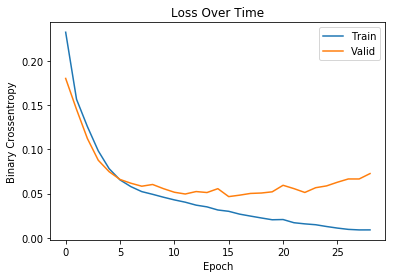

In [361]:
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

### biGRU

In [362]:
def create_bigru_model():
    model = Sequential()
    model.add(Embedding(domain_max_features, 
                        128, 
                        input_length=domain_maxlen))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(att.AttentionLayer())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [363]:
reload(att)
bigru_model = create_bigru_model()

filepath = 'model/bigru/bigru_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

bigru_history = bigru_model.fit(X_train_deep_10w, y_train_deep_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = bigru_model.to_json()  # 保存模型结构
open('model/bigru/bigru_model_architecture.json', 'w').write(json_string)

pickle.dump(bigru_history.history, open('model/bigru/bigru_history.pkl', 'wb'))

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 57s - loss: 0.2667 - acc: 0.8882 - val_loss: 0.2060 - val_acc: 0.9203
Epoch 2/500
90000/90000 [==============================] - 52s - loss: 0.1651 - acc: 0.9389 - val_loss: 0.1495 - val_acc: 0.9467
Epoch 3/500
90000/90000 [==============================] - 51s - loss: 0.1268 - acc: 0.9552 - val_loss: 0.1222 - val_acc: 0.9574
Epoch 4/500
90000/90000 [==============================] - 50s - loss: 0.1048 - acc: 0.9633 - val_loss: 0.1025 - val_acc: 0.9649
Epoch 5/500
90000/90000 [==============================] - 50s - loss: 0.0876 - acc: 0.9692 - val_loss: 0.0863 - val_acc: 0.9687
Epoch 6/500
90000/90000 [==============================] - 50s - loss: 0.0709 - acc: 0.9748 - val_loss: 0.0701 - val_acc: 0.9746
Epoch 7/500
90000/90000 [==============================] - 50s - loss: 0.0659 - acc: 0.9771 - val_loss: 0.0666 - val_acc: 0.9781
Epoch 8/500
90000/90000 [======================

In [364]:
bigru_model = load_model('bigru')
evaluate_result(y_train_deep_10w, None, bigru_model.predict(X_train_deep_10w))
evaluate_result(y_test_deep_10w, None, bigru_model.predict(X_test_deep_10w))

Accuracy: 99.5890% 	 Precision: 99.7000% 	 Recall: 99.5442% 	 Roc: 0.9997	F1: 0.9962
Confusion:
[[45424   163]
 [  248 54165]]
Accuracy: 98.4200% 	 Precision: 98.6572% 	 Recall: 98.4593% 	 Roc: 0.9977	F1: 0.9856
Confusion:
[[ 8884   147]
 [  169 10800]]


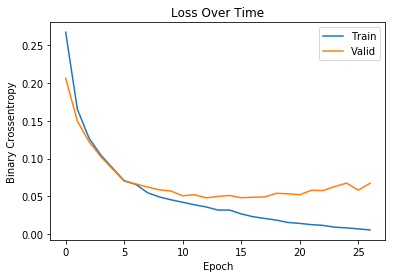

In [365]:
plt.plot(bigru_history.history['loss'])
plt.plot(bigru_history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4.3 Merged Methods

### LSTM + DNN
- 双模型融合

In [366]:
artifical_num=45
def create_dnn_lstm_model():
    artifical_input = Input(shape=(artifical_num,))
    domain_input = Input(shape=(domain_maxlen,))
    
    # dnn
    dnn_dense_1 = Dense(128, activation='relu')(artifical_input)
    dnn_dropout_1 = Dropout(rate=0.5)(dnn_dense_1)
    dnn_output = Dense(1, activation='sigmoid')(dnn_dropout_1)
    dnn_model = Model(inputs=artifical_input, output=dnn_output)
    
    # lstm
    embedding_layer = Embedding(domain_max_features, 
                                128, 
                                input_length=domain_maxlen)(domain_input)
    lstm_dense = LSTM(128)(embedding_layer)
    lstm_dropout = Dropout(rate=0.5)(lstm_dense)
    lstm_output = Dense(1, activation='sigmoid')(lstm_dropout)
    lstm_model = Model(inputs=domain_input, output=lstm_output)
    
    # embedding
    merged_layer = Concatenate(axis=-1)([dnn_output, lstm_output])
    merged_output = Dense(1, activation='sigmoid')(merged_layer)
    combined_model = Model(inputs=[dnn_model.input] + [lstm_model.input], output=merged_output)
    
    # final model
    combined_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return combined_model

In [367]:
dnn_lstm_model = create_dnn_lstm_model()

filepath = 'model/dnn_lstm/dnn_lstm_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

dnn_lstm_history = dnn_lstm_model.fit([X_train_10w] + [X_train_deep_10w], y_train_deep_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = dnn_lstm_model.to_json()  # 保存模型结构
open('model/dnn_lstm/dnn_lstm_model_architecture.json', 'w').write(json_string)

pickle.dump(dnn_lstm_history.history, open('model/dnn_lstm/dnn_lstm_history.pkl', 'wb'))

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 40s - loss: 0.4474 - acc: 0.8884 - val_loss: 0.3727 - val_acc: 0.9148
Epoch 2/500
90000/90000 [==============================] - 35s - loss: 0.3199 - acc: 0.9396 - val_loss: 0.2822 - val_acc: 0.9468
Epoch 3/500
90000/90000 [==============================] - 33s - loss: 0.2544 - acc: 0.9519 - val_loss: 0.2322 - val_acc: 0.9530
Epoch 4/500
90000/90000 [==============================] - 33s - loss: 0.2105 - acc: 0.9594 - val_loss: 0.1949 - val_acc: 0.9617
Epoch 5/500
90000/90000 [==============================] - 33s - loss: 0.1774 - acc: 0.9654 - val_loss: 0.1669 - val_acc: 0.9648
Epoch 6/500
90000/90000 [==============================] - 33s - loss: 0.1526 - acc: 0.9689 - val_loss: 0.1450 - val_acc: 0.9698
Epoch 7/500
90000/90000 [==============================] - 34s - loss: 0.1321 - acc: 0.9725 - val_loss: 0.1260 - val_acc: 0.9725
Epoch 8/500
90000/90000 [======================

In [368]:
dnn_lstm_model = load_model('dnn_lstm')
evaluate_result(y_train_deep_10w, None, dnn_lstm_model.predict([X_train_10w] + [X_train_deep_10w]))
evaluate_result(y_test_deep_10w, None, dnn_lstm_model.predict([X_test_10w] + [X_test_deep_10w]))

Accuracy: 99.2920% 	 Precision: 99.6983% 	 Recall: 98.9984% 	 Roc: 0.9989	F1: 0.9935
Confusion:
[[45424   163]
 [  545 53868]]
Accuracy: 98.8800% 	 Precision: 99.3932% 	 Recall: 98.5596% 	 Roc: 0.9984	F1: 0.9897
Confusion:
[[ 8965    66]
 [  158 10811]]


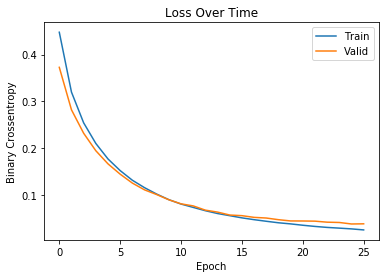

In [369]:
plt.plot(dnn_lstm_history.history['loss'])
plt.plot(dnn_lstm_history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

#### 五折交叉验证

In [370]:
X_train_min_max_scaler.shape, X_train_deep.shape, X_test_min_max_scaler.shape, X_test_deep.shape, y_train.shape, y_test.shape

((1759959, 45),
 (1759959, 64),
 (439990, 45),
 (439990, 64),
 (1759959,),
 (439990,))

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
n_fold = 0
dnn_lstm_models = list()
for train_index, valid_index in kfold.split(X_train_deep, y_train):
    n_fold += 1
    print("Fold_{}".format(n_fold))
    
    # 数据准备
    X_train_artifical_fold = X_train_min_max_scaler[train_index]
    X_train_deep_fold = X_train_deep[train_index]
    X_valid_artifical_fold = X_train_min_max_scaler[valid_index]
    X_valid_deep_fold = X_train_deep[valid_index]
    y_train_fold = y_train.values[train_index]
    y_valid_fold = y_train.values[valid_index]

    # 模型构建
    dnn_lstm_model = create_dnn_lstm_model()

    # 模型训练
    filepath = 'model/dnn_lstm/dnn_lstm_model_weights_fold_{}.best.h5'.format(n_fold)
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_acc', patience=5)
    callback_list = [checkpoint, early_stopping]

    dnn_lstm_history = dnn_lstm_model.fit([X_train_artifical_fold] + [X_train_deep_fold], y_train_fold, 
                  epochs=500, batch_size=256, shuffle=True,
                  validation_data=[[X_valid_artifical_fold] + [X_valid_deep_fold], y_valid_fold], 
                  callbacks=callback_list, verbose=1)  # 训练模型
    pickle.dump(dnn_lstm_history.history, open('model/dnn_lstm/dnn_lstm_history_fold_{}.pkl'.format(n_fold), 'wb'))
    dnn_lstm_models.append(dnn_lstm_model)

Fold_1
Train on 1407967 samples, validate on 351992 samples
Epoch 1/500
1407967/1407967 [==============================] - 549s - loss: 0.1245 - acc: 0.9716 - val_loss: 0.0477 - val_acc: 0.9895
Epoch 2/500
1407967/1407967 [==============================] - 546s - loss: 0.0374 - acc: 0.9905 - val_loss: 0.0291 - val_acc: 0.9917
Epoch 3/500
1407967/1407967 [==============================] - 550s - loss: 0.0264 - acc: 0.9925 - val_loss: 0.0230 - val_acc: 0.9933
Epoch 4/500
1407967/1407967 [==============================] - 543s - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0209 - val_acc: 0.9938
Epoch 5/500
1407967/1407967 [==============================] - 547s - loss: 0.0209 - acc: 0.9938 - val_loss: 0.0218 - val_acc: 0.9932
Epoch 6/500
1407967/1407967 [==============================] - 553s - loss: 0.0184 - acc: 0.9942 - val_loss: 0.0178 - val_acc: 0.9942
Epoch 7/500
1407967/1407967 [==============================] - 547s - loss: 0.0169 - acc: 0.9946 - val_loss: 0.0173 - val_acc: 0.9943
Ep

In [382]:
# 加载五折模型
dnn_list_models = list()
for i in range(1,6):
    model = create_dnn_lstm_model()
    weight_path = 'model/dnn_lstm/dnn_lstm_model_weights_fold_{}.best.h5'.format(i)
    model.load_weights(weight_path)
    dnn_list_models.append(model)

In [383]:
# 评估在测试集上的结果
y_test_preds = list()
for i in range(5):
    print("n_Fold:{}".format(i))
    model = dnn_list_models[i]
    y_test_pred = model.predict([X_test_min_max_scaler] + [X_test_deep]).flatten()
    evaluate_result(y_test, None, y_test_pred)
    y_test_preds.append(y_test_pred)

n_Fold:0
Accuracy: 99.5214% 	 Precision: 99.6792% 	 Recall: 99.4425% 	 Roc: 0.9997	F1: 0.9956
Confusion:
[[199232    768]
 [  1338 238652]]
n_Fold:1
Accuracy: 99.5057% 	 Precision: 99.6240% 	 Recall: 99.4691% 	 Roc: 0.9997	F1: 0.9955
Confusion:
[[199099    901]
 [  1274 238716]]
n_Fold:2
Accuracy: 99.4968% 	 Precision: 99.6422% 	 Recall: 99.4346% 	 Roc: 0.9997	F1: 0.9954
Confusion:
[[199143    857]
 [  1357 238633]]
n_Fold:3
Accuracy: 99.5186% 	 Precision: 99.6071% 	 Recall: 99.5100% 	 Roc: 0.9997	F1: 0.9956
Confusion:
[[199058    942]
 [  1176 238814]]
n_Fold:4
Accuracy: 99.5195% 	 Precision: 99.5794% 	 Recall: 99.5396% 	 Roc: 0.9998	F1: 0.9956
Confusion:
[[198991   1009]
 [  1105 238885]]


In [387]:
# 数据类型转化
y_test_preds_array = np.array(y_test_preds)
pickle.dump(y_test_preds_array, open('model/dnn_lstm/dnn_lstm_five_fold_result.pkl', 'wb'))
y_test_preds_array.shape

(5, 439990)

In [393]:
y_test_ensemble = y_test_preds_array.sum(axis=0) / 5.0
evaluate_result(y_test, None, y_test_ensemble)

Accuracy: 99.5859% 	 Precision: 99.7032% 	 Recall: 99.5371% 	 Roc: 0.9998	F1: 0.9962
Confusion:
[[199289    711]
 [  1111 238879]]


#### 分析五折后的误差

In [394]:
error_analysis_df = pd.DataFrame()
error_analysis_df['family'] = test_features_df['label'].values
error_analysis_df['label'] = y_test.values
error_analysis_df['proba'] = y_test_ensemble
error_analysis_df['pred'] = np.where(y_test_ensemble>0.5, 1, 0)
error_analysis_df.shape

(439990, 4)

In [395]:
error_analysis_df.head()

,family,label,proba,pred
0,banjori,1,0.999654,1
1,legit,0,0.004531,0
2,legit,0,0.010968,0
3,legit,0,0.000442,0
4,tinba,1,0.999882,1


In [396]:
evulation_df = pd.DataFrame()
evulation_df['accuracy'] = error_analysis_df.groupby(['family']).apply(lambda x: accuracy_score(x['label'], x['pred']))
evulation_df['precision'] = error_analysis_df.groupby(['family']).apply(lambda x: precision_score(x['label'], x['pred']))
evulation_df['recall'] = error_analysis_df.groupby(['family']).apply(lambda x: recall_score(x['label'], x['pred']))
evulation_df['F1'] = 2*(evulation_df['precision']*evulation_df['recall'])/(evulation_df['precision']+evulation_df['recall'])
evulation_df['support'] = error_analysis_df.groupby(['family']).apply(lambda x: x.shape[0])
evulation_df.sort_values(by='support', ascending=False, inplace=True)

In [399]:
evulation_df[['accuracy', 'support']]

,accuracy,support
family,,
legit,0.996445,200000
banjori,1.000000,90468
emotet,0.999773,66112
rovnix,0.999944,35987
tinba,0.996620,14498
pykspa_v1,0.993451,8856
simda,0.999368,4746
ramnit,0.961447,3787
gameover,1.000000,2399


In [400]:
evulation_df[evulation_df['accuracy']>=0.80].shape, evulation_df[evulation_df['accuracy']>=0.95].shape, evulation_df[evulation_df['accuracy']>=0.99].shape

((35, 5), (27, 5), (22, 5))

### lstm with manual DNN(lwm DNN)
- 特征融合

In [250]:
artifical_num=45
def create_lstm_with_manual_dnn_model():
    artifical_input = Input(shape=(artifical_num,))
    domain_input = Input(shape=(domain_maxlen,))
    
    # lstm
    embedding_layer = Embedding(domain_max_features, 
                                128, 
                                input_length=domain_maxlen)(domain_input)
    lstm_dense = LSTM(128)(embedding_layer)
    
    # merged
    merged_layer = Concatenate(axis=-1)([lstm_dense, artifical_input])
    
    # dnn
    merged_dnn_dense1 = Dense(256)(merged_layer)
    merged_dnn_dropout1 = Dropout(rate=0.5)(merged_dnn_dense1)
    merged_dnn_dense2 = Dense(128)(merged_dnn_dropout1)
    merged_dnn_dropout2 = Dropout(rate=0.5)(merged_dnn_dense2)
    merged_output = Dense(1, activation='sigmoid')(merged_dnn_dropout2)
    
    combined_model = Model(inputs=[artifical_input] + [domain_input], output=merged_output)
    
    # final model
    combined_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return combined_model

In [252]:
lwm_dnn_model = create_lstm_with_manual_dnn_model()

filepath = 'model/lwm_dnn/lwm_dnn_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

lwm_dnn_model.fit([X_train_10w] + [X_train_deep_10w], y_train_deep_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = lwm_dnn_model.to_json()  # 保存模型结构
open('model/lwm_dnn/lwm_dnn_model_architecture.json', 'w').write(json_string)

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 37s - loss: 0.1410 - acc: 0.9471 - val_loss: 0.0887 - val_acc: 0.9722
Epoch 2/500
90000/90000 [==============================] - 32s - loss: 0.0773 - acc: 0.9741 - val_loss: 0.0654 - val_acc: 0.9793
Epoch 3/500
90000/90000 [==============================] - 33s - loss: 0.0604 - acc: 0.9803 - val_loss: 0.0542 - val_acc: 0.9817
Epoch 4/500
90000/90000 [==============================] - 33s - loss: 0.0509 - acc: 0.9839 - val_loss: 0.0499 - val_acc: 0.9827
Epoch 5/500
90000/90000 [==============================] - 33s - loss: 0.0455 - acc: 0.9852 - val_loss: 0.0513 - val_acc: 0.9839
Epoch 6/500
90000/90000 [==============================] - 32s - loss: 0.0431 - acc: 0.9862 - val_loss: 0.0488 - val_acc: 0.9832
Epoch 7/500
90000/90000 [==============================] - 32s - loss: 0.0392 - acc: 0.9875 - val_loss: 0.0433 - val_acc: 0.9864
Epoch 8/500
90000/90000 [======================

4620

In [255]:
dnn_lstm_model = load_model('lwm_dnn')
evaluate_result(y_train_deep_10w, None, dnn_lstm_model.predict([X_train_10w] + [X_train_deep_10w]))
evaluate_result(y_test_deep_10w, None, dnn_lstm_model.predict([X_test_10w] + [X_test_deep_10w]))

Accuracy: 99.2450% 	 Precision: 99.4635% 	 Recall: 99.1473% 	 Roc: 0.9996
Confusion:
[[45296   291]
 [  464 53949]]
Accuracy: 98.8950% 	 Precision: 99.1494% 	 Recall: 98.8331% 	 Roc: 0.9988
Confusion:
[[ 8938    93]
 [  128 10841]]


## 4.4 多分类

In [295]:
def create_multi_lstm_model():
    model = Sequential()
    model.add(Embedding(domain_max_features, 
                        128, 
                        input_length=domain_maxlen))
    model.add(LSTM(128))
    model.add(Dense(42, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [296]:
multi_lstm_model = create_multi_lstm_model()

filepath = 'model/lstm/multi_lstm_model_weights.best.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,
                            save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callback_list = [checkpoint, early_stopping]

multi_lstm_model.fit(X_train_deep_10w, y_train_deep_multi_10w, 
              epochs=500, batch_size=256, shuffle=True,
              validation_split=0.1, callbacks=callback_list, verbose=1)  # 训练模型

json_string = multi_lstm_model.to_json()  # 保存模型结构
open('model/lstm/multi_lstm_model_architecture.json', 'w').write(json_string)

Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 36s - loss: 0.8959 - acc: 0.7622 - val_loss: 0.4300 - val_acc: 0.8930
Epoch 2/500
90000/90000 [==============================] - 32s - loss: 0.3501 - acc: 0.9075 - val_loss: 0.3029 - val_acc: 0.9216
Epoch 3/500
90000/90000 [==============================] - 32s - loss: 0.2549 - acc: 0.9339 - val_loss: 0.2231 - val_acc: 0.9388
Epoch 4/500
90000/90000 [==============================] - 32s - loss: 0.2014 - acc: 0.9485 - val_loss: 0.1832 - val_acc: 0.9541
Epoch 5/500
90000/90000 [==============================] - 32s - loss: 0.1663 - acc: 0.9577 - val_loss: 0.1655 - val_acc: 0.9563
Epoch 6/500
90000/90000 [==============================] - 32s - loss: 0.1440 - acc: 0.9628 - val_loss: 0.1433 - val_acc: 0.9630
Epoch 7/500
90000/90000 [==============================] - 32s - loss: 0.1297 - acc: 0.9656 - val_loss: 0.1282 - val_acc: 0.9653
Epoch 8/500
90000/90000 [======================

1842

In [298]:
scores = multi_lstm_model.evaluate(x=X_test_deep_10w, y=y_test_deep_multi_10w, verbose=0)
print('Accuracy: %.2f%%' % (scores[1] * 100))

Accuracy: 97.41%


## BERT (尚未完成)

#### bert-tokenizer

In [183]:
X_train_domain.shape, y_train.shape

((1759959,), (1759959,))

#### 训练与使用

In [194]:
def generate_domain_pair(X, y):
    domain_pair = list()
    for i in range(len(X)):
        pair = list()
        domain = X[i]
        split_domain = [x for x in domain]
        label = ['legit'] if y[i]==0 else ['dga']
        pair.append(split_domain)
        pair.append(label)
        domain_pair.append(pair)
    return domain_pair

train_pair = generate_domain_pair(X_train_domain.fillna('').tolist(), 
                                  y_train.tolist())
test_pair = generate_domain_pair(X_test_domain.fillna('').tolist(), 
                                 y_test.tolist())
len(train_pair), len(test_pair)

(1759959, 439990)

In [195]:
# Build token dictionary
token_dict = get_base_dict()  # A dict that contains some special tokens
for pairs in train_pair:
    for token in pairs[0] + pairs[1]:
        if token not in token_dict:
            token_dict[token] = len(token_dict)
token_list = list(token_dict.keys())  # Used for selecting a random word

In [204]:
# Build & train the model
model = get_model(
    token_num=len(token_dict),
    head_num=32,
    transformer_num=12,
    embed_dim=128,
    feed_forward_dim=100,
    seq_len=64,
    pos_num=64,
    dropout_rate=0.05,
)
compile_model(model)

In [ ]:
def _generator():
    while True:
        yield gen_batch_inputs(
            train_pair,
            token_dict,
            token_list,
            seq_len=20,
            mask_rate=0.3,
            swap_sentence_rate=1.0,
        )

model.fit_generator(
    generator=_generator(),
    steps_per_epoch=1000,
    epochs=100,
    validation_data=_generator(),
    validation_steps=100,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5)
    ],
)